# Imports

In [89]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION

# Load (Preprocessed Step 1) DTU Solar Station data

In [90]:
df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
df = df[sorted(df.columns)]
df_raw = df.copy()

print(df.shape)
print(df.info())
df.head()

(2460742, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460742 entries, 2015-03-12 05:36:00 to 2025-01-01 08:04:00
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DHI                float64
 1   DNI                float64
 2   air_pressure       float64
 3   air_temperature    float64
 4   rain_duration      float64
 5   rain_intensity     float64
 6   relative_humidity  float64
 7   solar_altitude     float64
 8   wind_dir_avg       float64
 9   wind_speed_avg     float64
dtypes: float64(10)
memory usage: 206.5 MB
None


,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2015-03-12 05:36:00,2.890,0.000000,1028.0,0.0,0.0,0.0,81.6,0.004880,85.0,1.0
2015-03-12 05:37:00,3.128,0.000000,1028.0,0.0,0.0,0.0,81.9,0.120481,121.0,0.3
2015-03-12 05:38:00,3.307,0.814740,1028.0,0.0,0.0,0.0,81.7,0.237359,342.0,0.7
2015-03-12 05:39:00,3.657,26.392772,1028.0,0.0,0.0,0.0,81.6,0.355447,342.0,0.7
2015-03-12 05:40:00,4.056,61.929423,1028.0,0.0,0.0,0.0,81.5,0.474681,302.0,1.2


# Lag values

In [91]:
TARGET = 'DHI'
full_range = pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq="1min")
df = df_raw[TARGET].copy().to_frame()
df = df.reindex(full_range)
df.sort_index(inplace=True)
mask = df.isna().values
df[mask] = 0
lf = LagFeatures(periods=[60], drop_original=False, drop_na=False)
df = lf.fit_transform(df)
df = df[~mask]
df = df.dropna()
df

,DHI,DHI_lag_60
2015-03-12 06:36:00,27.93,2.890
2015-03-12 06:37:00,28.29,3.128
2015-03-12 06:38:00,28.70,3.307
2015-03-12 06:39:00,29.17,3.657
2015-03-12 06:40:00,29.48,4.056
...,...,...
2025-01-01 08:00:00,0.00,0.000
2025-01-01 08:01:00,0.00,0.000
2025-01-01 08:02:00,0.00,0.000
2025-01-01 08:03:00,0.00,0.000


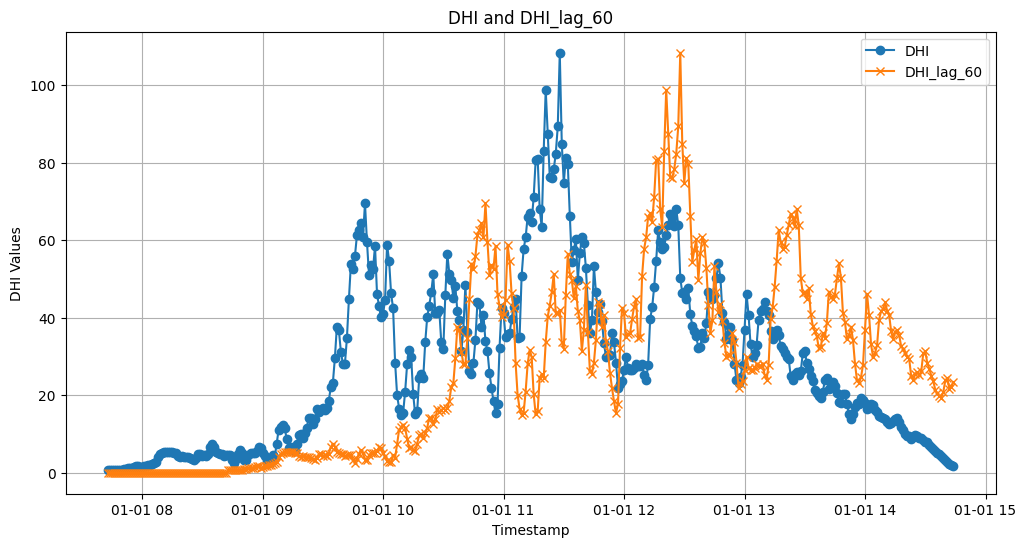

In [92]:
import matplotlib.pyplot as plt

# Select a subset of the data for plotting
subset = df.loc['2023-01-01']

# Plot the original and lagged values
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['DHI'], label='DHI', marker='o')
plt.plot(subset.index, subset['DHI_lag_60'], label='DHI_lag_60', marker='x')
plt.title('DHI and DHI_lag_60')
plt.xlabel('Timestamp')
plt.ylabel('DHI Values')
plt.legend()
plt.grid()
plt.show()

# Datasplitting

In [94]:
train_df = df.loc[:'2020']
val_df = df.loc['2021':'2022']
test_df = df.loc['2023':]
print(train_df.shape, val_df.shape, test_df.shape)

(1427680, 2) (511008, 2) (521994, 2)


In [95]:
test_df.to_csv('./output/test.csv', index=True)

In [96]:
test_df

,DHI,DHI_lag_60
2023-01-01 07:43:00,0.7792,0.0
2023-01-01 07:44:00,0.7531,0.0
2023-01-01 07:45:00,0.7564,0.0
2023-01-01 07:46:00,0.7398,0.0
2023-01-01 07:47:00,0.7124,0.0
...,...,...
2025-01-01 08:00:00,0.0000,0.0
2025-01-01 08:01:00,0.0000,0.0
2025-01-01 08:02:00,0.0000,0.0
2025-01-01 08:03:00,0.0000,0.0


# Persistence model

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Actual and predicted values
y_true = test_df['DHI']
y_pred = test_df['DHI_lag_60']

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-6))) * 100  # avoid division by zero

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_true.values, label='Actual DHI')
plt.plot(y_pred.values, label='Persistence Forecast (DHI_lag_60)', linestyle='--')
plt.title('Persistence Model Forecast vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DHI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

(mae, rmse, mape)


In [ ]:
import numpy as np
gap_threshold_timedelta = np.timedelta64(1, 'm')

df = test_df.copy()
df['Residual'] = df[TARGET] - df['DHI_lag_60']

for i in range(0, len(df) - 60, 60):
    # Get the input sequence and the target value
    input_seq = df.iloc[i: i + 60]['DHI_lag_60'].values
    target_value = df.iloc[i: i + 60]['DHI'].values
    
    # Get timestamps for the entire sequence (input and forecast)
    seq_timestamps = input_seq.index
    # Calculate differences between consecutive timestamps
    time_diffs = np.diff(seq_timestamps)
    if np.any(time_diffs > gap_threshold_timedelta):
        continue

    residuals = target_value - input_seq
    # Print the input sequence and target value
    print(f"Input Sequence:\n{input_seq}")
    print(f"Target Value:\n{target_value}")